In [142]:
import os
import numpy as np
from PIL import Image
import keras
from tensorflow.keras.layers import Dense, Dropout, Activation
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split

## Test avec code de Sergio

# Vrai truc qui marche

In [7]:
def load_dataset(path_to_data,nb_im) :

    img_list = os.listdir(path_to_data)
    img_pixel_list = []

    for i in range(nb_im):
        img = Image.open(f'{path_to_data}/{img_list[i]}')
        img = img.resize((60, 76))
        img = np.array(img)
        img_pixel_list.append(img)

    img_pixel_list = np.array(img_pixel_list)
    img_pixel_list = img_pixel_list.astype('float32') / 255.0 # il faut normaliser pour + de puissance
    #img_pixel_list = img_pixel_list.reshape((len(img_pixel_list), np.prod(img_pixel_list.shape[1:])))  # on met ça en vecteur 1D en ligne, mais pas besoin avec conv2D
    
    return img_pixel_list

In [153]:
def encodeur_decodeur():
    """
    
    Renvoie l'auto encodeur, l'encodeur et le décodeur compilés
    
    
    """

    input_shape = (76, 60, 3) #taille des images de départ
    dropout_level = 0.1 #Dropout level, on verra si on utilise plus tard

    
    # Couches de l'encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    print(encoded.shape[1:])

    # Couches du décoder
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    nb_decoded_layers = 5 #à ajouter si on ajoute une couche au décodeur
    
    #Création encoder, autoencoder
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    
    
    #Récupération des couches pour le décoder
    input_encoded_img = keras.Input(shape=(encoded.shape[1:])) #dimension de l'objet encodé
    y = autoencoder.layers[-nb_decoded_layers](input_encoded_img)
    
    for i in range(nb_decoded_layers-1,0,-1): # 4 3 2 1
        y = autoencoder.layers[-i](y)
    
    # Decoder
    decoder = Model(input_encoded_img, y)
    
    #On compile uniquement l'auto encoder
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    
    return autoencoder,encoder,decoder

In [69]:
def plot_loss(autoencoder):
    """
    Plot la loss de l'auto encodeur : si on a un bon modèele, val loss est proche de loss, et on veut une loss faible
    """

    history = autoencoder.history.history

    plt.plot(history['val_loss'],label="test")
    plt.plot(history['loss'],label="training")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()

In [70]:
def plot_image_reconstruction(autoencoder,X_test,n=10):

    """n : combien de faces on display
    X_test : l'array des images tests"""
    
    decoded_imgs = autoencoder.predict(X_test)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(76, 60,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(76, 60,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Tests des fonctions

In [87]:
img_pixel_list = load_dataset('/home/fannie/Documents/S2/Logiciel/Projet_logiciel/CelebA/Img/img_align_celeba',2000)

In [88]:
X_train, X_test = train_test_split(img_pixel_list,
                                   test_size=0.2, 
                                   random_state=0)

In [154]:
autoencoder,encoder,decoder = encodeur_decodeur()
autoencoder.summary()
#encoder.summary()
#decoder.summary()

(19, 15, 32)
Model: "model_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 76, 60, 3)]       0         
                                                                 
 conv2d_155 (Conv2D)         (None, 76, 60, 32)        896       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 38, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_156 (Conv2D)         (None, 38, 30, 32)        9248      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 19, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_157 (Conv2D)         (None, 19, 15, 3

In [245]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=50,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/20
32/32 [==============================] - 13s 402ms/step - loss: 0.4836 - val_loss: 0.4841
Epoch 2/20
32/32 [==============================] - 16s 490ms/step - loss: 0.4834 - val_loss: 0.4836
Epoch 3/20
32/32 [==============================] - 14s 445ms/step - loss: 0.4832 - val_loss: 0.4838
Epoch 4/20
32/32 [==============================] - 16s 512ms/step - loss: 0.4834 - val_loss: 0.4837
Epoch 5/20
32/32 [==============================] - 17s 538ms/step - loss: 0.4832 - val_loss: 0.4837
Epoch 6/20
32/32 [==============================] - 15s 476ms/step - loss: 0.4831 - val_loss: 0.4835
Epoch 7/20
32/32 [==============================] - 14s 437ms/step - loss: 0.4831 - val_loss: 0.4843
Epoch 8/20
32/32 [==============================] - 16s 502ms/step - loss: 0.4844 - val_loss: 0.4849
Epoch 9/20
32/32 [==============================] - 14s 423ms/step - loss: 0.4838 - val_loss: 0.4838
Epoch 10/20
32/32 [==============================] - 14s 440ms/step - loss: 0.4830 - val_lo

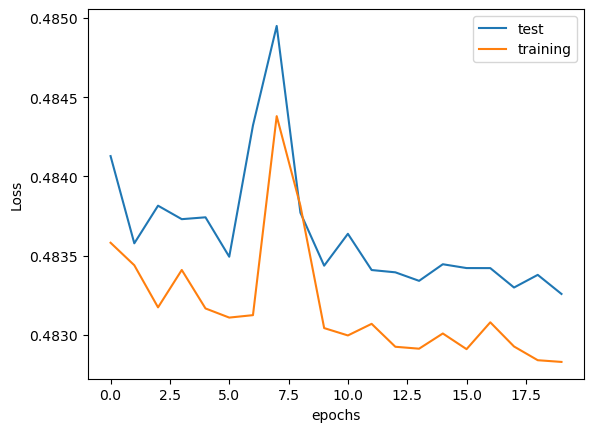

In [246]:
plot_loss(autoencoder)

13/13 [==============================] - 1s 94ms/step


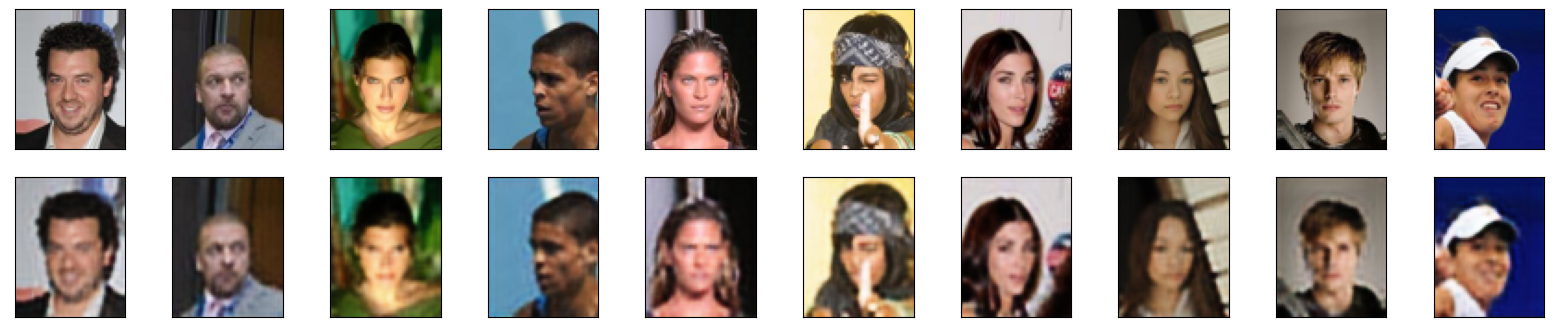

In [247]:
plot_image_reconstruction(autoencoder,X_test) #plot le résultat de l'encodeur pas séparé

In [248]:
autoencoder.save("./Model/model_20epochs_batch_50")

INFO:tensorflow:Assets written to: ./Model/model_20epochs_batch_50/assets


INFO:tensorflow:Assets written to: ./Model/model_20epochs_batch_50/assets


# Load model

In [249]:
autoencoder_saved=load_model("./Model/model_20epochs_batch_50")

13/13 [==============================] - 1s 91ms/step


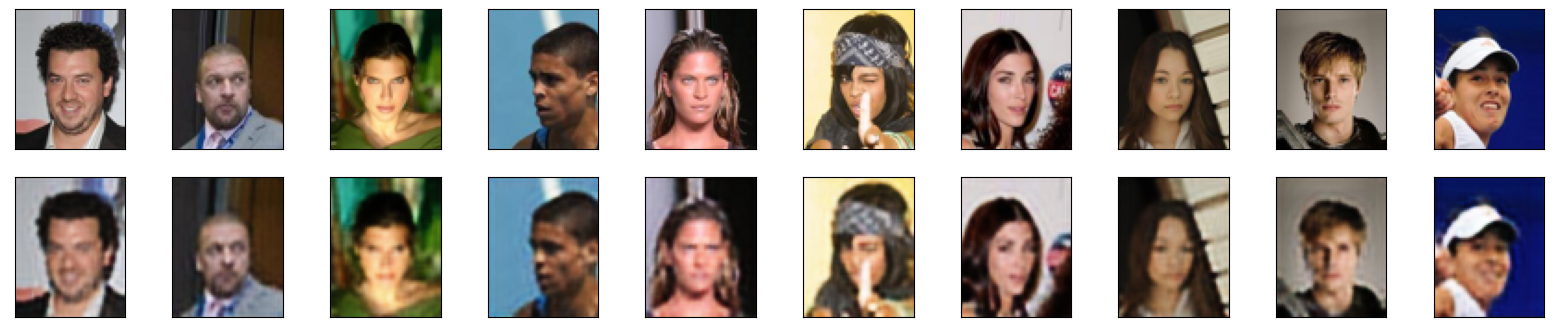

In [250]:
plot_image_reconstruction(autoencoder_saved,X_test)

In [166]:
autoencoder_saved.history.history

{}

## Test du bruit sur X_test

In [99]:
X_test_encoded = encoder.predict(X_test) #images encodées

13/13 [==============================] - 1s 59ms/step


In [94]:
for i in range (10) :

    a,b,c = X_test_encoded[i].shape
    X_test_encoded[i] = X_test_encoded[i] + 2*np.random.rand(a,b,c) #on ajute du bruit sur l'encodage

In [101]:
X_test_decoded_noisy = decoder.predict(X_test_encoded)

13/13 [==============================] - 0s 32ms/step


In [102]:
X_test_decoded_noisy.shape

(400, 40, 32, 3)

ValueError: cannot reshape array of size 3840 into shape (76,60,3)

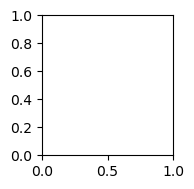

In [97]:
plt.figure(figsize=(20, 4))
for i in range (10) :
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test_decoded_noisy[i].reshape(76, 60,3))